In [1]:
import os
import numpy as np

from astropy.io import fits

import sep

from properimage import propercoadd as pc
from properimage import utils

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#import seaborn as sns
#sns.set_context('poster')

In [3]:
imgfile = './test_frame.fits'

In [4]:
img = fits.open(imgfile)

In [5]:
img[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  

In [6]:
dat = img[0].data.byteswap().newbyteorder()
bkg = sep.Background(dat)
src = sep.extract(dat - bkg, thresh=5.*bkg.globalrms)

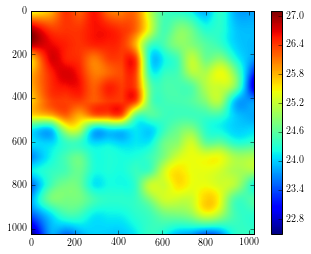

In [60]:
plt.imshow(bkg.rms())
plt.colorbar()

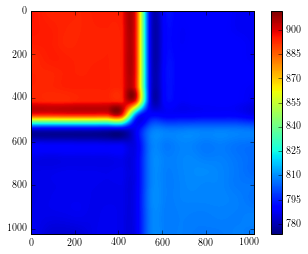

In [63]:
plt.imshow(bkg.back())
plt.colorbar()

In [16]:
reload(pc)

<module 'properimage.propercoadd' from '/home/bruno/Devel/zackay_code/properimage/properimage/propercoadd.pyc'>

In [125]:
im = pc.SingleImage(imgfile, pow_th=0.003)

In [126]:
afields, psf = im.get_variable_psf()

background subtracted image obtained
background subtracted image obtained
raw sources = 350
Sources good to calculate = 180
returning best sources

Fitshape = (15, 15)
obtainig KL basis, using k = 6
returning variable psf


In [19]:
len(psf)

9

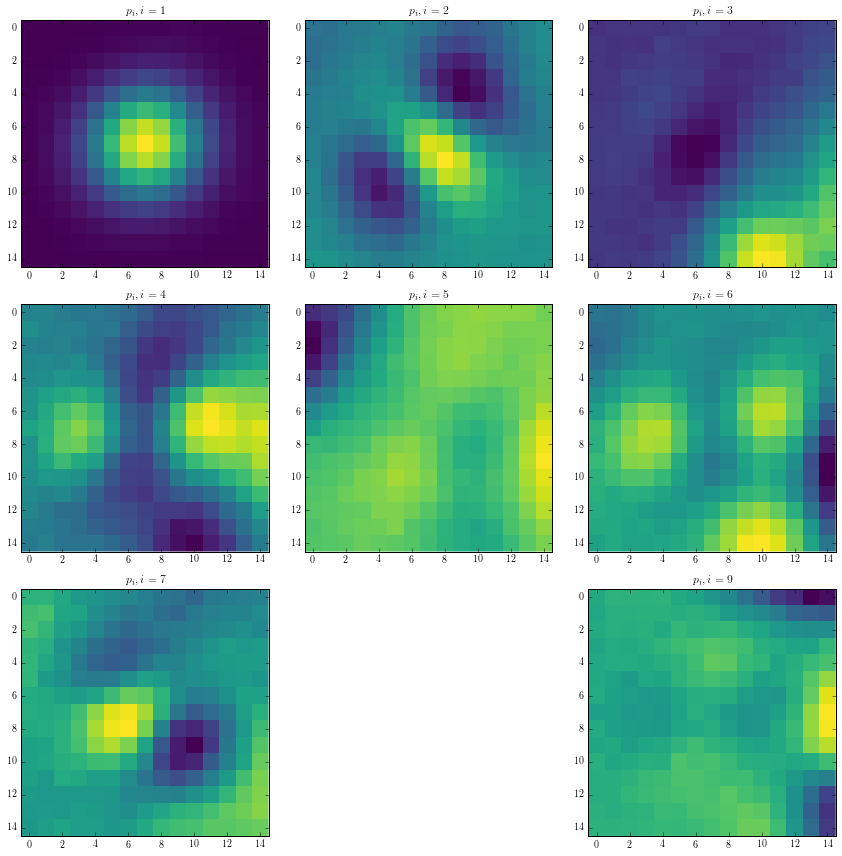

In [20]:
utils.plot_psfbasis(psf_basis=psf, nbook=True)

In [21]:
im._best_sources.keys()

['fitshape', 'sources', 'n_sources', 'positions']

In [22]:
fitshape = im._best_sources['fitshape']

In [23]:
from astropy.modeling import models, fitting

In [24]:
fitted = []
params = []
y, x = np.mgrid[:fitshape[1], :fitshape[0]]
for pos in im._best_srcs['positions']:
    star_model = models.Gaussian2D(x_mean=fitshape[0]/2., y_mean=fitshape[0]/2.,
                                   x_stddev=1., y_stddev=1., theta=0.)+models.Const2D()
    fitter = fitting.LevMarLSQFitter()

    star = pc.extract_array(im.bkg_sub_img, fitshape, pos, fill_value=im.bkg.globalrms)
    star = star/np.sum(star)
    fit = fitter(star_model, y, x, star, maxiter=5000)
    
    fitted.append(fit)
    gauss_param=fit[0]
    background=fit[1]
    
    ymodel,xmodel=np.mgrid[:fitshape[0],:fitshape[1]]

    resid = np.sqrt(np.sum(np.square(star - fit(xmodel,ymodel))))/(fitshape[0]*fitshape[1])

    elip = abs((gauss_param.x_stddev - gauss_param.y_stddev)/(gauss_param.x_stddev + gauss_param.y_stddev))
    th = np.rad2deg(gauss_param.theta)
    ab=gauss_param.x_stddev*gauss_param.y_stddev
    amp=gauss_param.amplitude.value
    if gauss_param.x_stddev > gauss_param.y_stddev:
        theta=(th- int(th/180)*180.)
    else:
        theta=((th- int(th/180)*180.)-90)
    if theta > 0:
        theta=180.-theta
    else:
        theta=abs(theta)
    if theta >180.:
        theta=theta-180.
    theta=180.-theta
    
    params.append([gauss_param.x_stddev[0], gauss_param.y_stddev[0], elip, theta, ab, amp, pos[0], pos[1]])

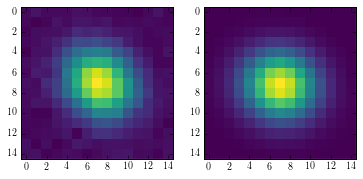

In [25]:
plt.subplot(121)
plt.imshow(star, interpolation='none', cmap='viridis')
plt.subplot(122)
plt.imshow(fitted[-1](x, y), cmap='viridis', interpolation='none')


In [26]:
import pandas as pd

In [27]:
shapes = pd.DataFrame(params, columns=['sgx', 'sgy', 'elip', 'theta', 'ab', 'amp', 'x', 'y'])

In [28]:
shapes.describe()

,sgx,sgy,elip,theta,ab,amp,x,y
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,2.320652,2.247502,1.253445,89.344830,5.130345,0.028762,455.989589,442.975046
std,0.649785,0.984179,8.578165,47.259137,3.426766,0.005909,271.180574,276.581590
min,-2.619640,-3.693588,0.000149,6.494080,-13.941371,0.011659,32.994298,30.022802
25%,2.135145,2.130023,0.003900,46.944748,4.578739,0.024389,235.518759,219.953161
50%,2.163843,2.153891,0.035878,96.119949,5.207671,0.029626,389.380589,399.657389
75%,2.473411,2.424018,0.125003,128.916767,6.014182,0.034577,696.356694,677.840670
max,4.551259,7.976931,92.322814,174.774414,26.047274,0.037534,975.028865,974.859601


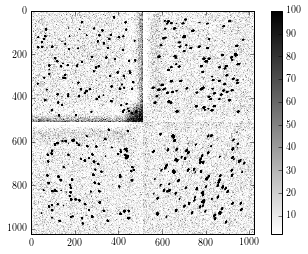

In [29]:
plt.imshow(im.bkg_sub_img, vmax=100., vmin=2, cmap='gray_r')
plt.colorbar()

In [30]:
quad1 = shapes[(shapes.x<512.)&(shapes.y<=512.)]
quad2 = shapes[(shapes.x>=512.)&(shapes.y<=512.)]
quad3 = shapes[(shapes.x<512.)&(shapes.y>512.)]
quad4 = shapes[(shapes.x>=512.)&(shapes.y>512.)]

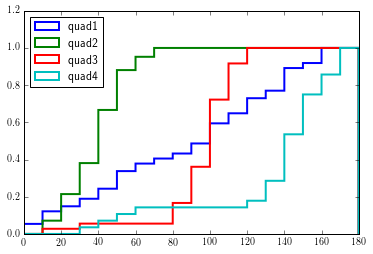

In [31]:
bins = np.arange(0, 190., 10.)
plt.hist(quad1.theta, cumulative=True, normed=True, bins=bins, label='quad1', histtype='step', linewidth=2.)
plt.hist(quad2.theta, cumulative=True, normed=True, bins=bins, label='quad2', histtype='step', linewidth=2.)
plt.hist(quad3.theta, cumulative=True, normed=True, bins=bins, label='quad3', histtype='step', linewidth=2.)
plt.hist(quad4.theta, cumulative=True, normed=True, bins=bins, label='quad4', histtype='step', linewidth=2.)
plt.legend(loc='upper left')
plt.show()

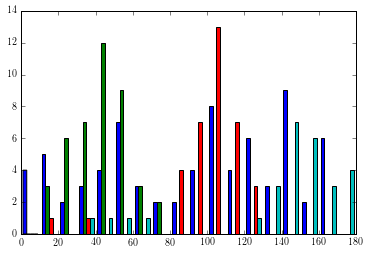

In [32]:
bins = np.arange(0, 190., 10.)
plt.hist([quad1.theta, quad2.theta, quad3.theta, quad4.theta],
         bins=bins, alpha=1, label='quad1', histtype='bar')
plt.show()

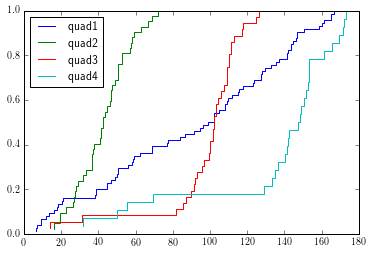

In [33]:
from statsmodels.distributions.empirical_distribution import ECDF\

ecdf1 = ECDF(quad1.theta)
ecdf2 = ECDF(quad2.theta)
ecdf3 = ECDF(quad3.theta)
ecdf4 = ECDF(quad4.theta)
plt.step(ecdf1.x, ecdf1.y, label='quad1')
plt.step(ecdf2.x, ecdf2.y, label='quad2')
plt.step(ecdf3.x, ecdf3.y, label='quad3')
plt.step(ecdf4.x, ecdf4.y, label='quad4')
plt.legend(loc='upper left')
plt.show()

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   5.,   9.,  11.,  12.,  13.,  13.,  14.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95]),
 <a list of 19 Patch objects>)

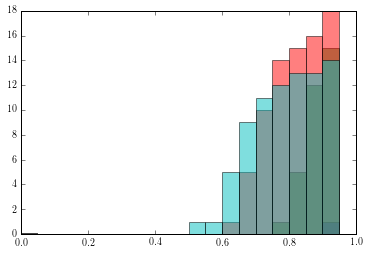

In [34]:
bins = np.arange(0, 1, 0.05)
plt.hist(quad1.sgy/quad1.sgx, bins=bins, cumulative=True, alpha=0.5)
plt.hist(quad2.sgy/quad2.sgx, bins=bins, cumulative=True, alpha=0.5)
plt.hist(quad3.sgy/quad3.sgx, bins=bins, cumulative=True, alpha=0.5)
plt.hist(quad4.sgy/quad4.sgx, bins=bins, cumulative=True, alpha=0.5)

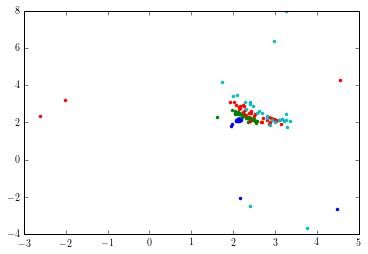

In [35]:
plt.plot(quad1.sgx, quad1.sgy, '.')
plt.plot(quad2.sgx, quad2.sgy, '.')
plt.plot(quad3.sgx, quad3.sgy, '.')
plt.plot(quad4.sgx, quad4.sgy, '.')

[2.1405032508738104, 2.139842954988568, 102.13278198242188]
[2.273525036813715, 2.2735007313048374, 43.088790893554688]
[2.4641193044312493, 2.3713018187803225, 102.94697570800781]
[2.8500365486041468, 2.3939059686794839, 148.70100402832031]


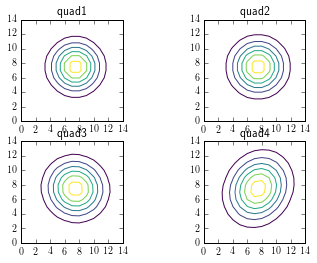

In [36]:
i=1
for aquad in [quad1, quad2, quad3, quad4]:
    m_sx = np.median(aquad.sgx)
    m_sy = np.median(aquad.sgy)
    m_th = np.median(aquad.theta)
    print [m_sx, m_sy, m_th]
    plt.subplot(2, 2, i, aspect='equal')
    stamp = models.Gaussian2D(x_mean=fitshape[0]/2., y_mean=fitshape[1]/2., 
                              x_stddev=m_sx, y_stddev=m_sy, theta=m_th)
    plt.contour(stamp(x, y), cmap='viridis')
    plt.title('quad{}'.format(i))
    
    #plt.grid()
    i+=1

In [37]:
fitted = []
params = []
star_staq = [np.zeros(fitshape) for i in range(4)]
cum = [0, 0, 0, 0]
y, x = np.mgrid[:fitshape[1], :fitshape[0]]
for pos in im._best_srcs['positions']:
    if pos[1]<512 and pos[0]<=512:
        i_quad = 0
    elif pos[1]>=512 and pos[0]<=512:
        i_quad = 1
    elif pos[1]<512 and pos[0]>512: 
        i_quad = 2
    elif pos[1]>=512 and pos[0]>512:  
        i_quad = 3
    
    star_staq[i_quad] += pc.extract_array(im.bkg_sub_img, fitshape, pos, fill_value=im.bkg.globalrms)
    cum[i_quad] += 1


for i_quad in range(4):
    star_staq[i_quad] = star_staq[i_quad]/cum[i_quad]
    star_staq[i_quad] = star_staq[i_quad]/np.sum(star_staq[i_quad])

    star_model = models.Gaussian2D(x_mean=fitshape[0]/2., y_mean=fitshape[0]/2.,
                                   x_stddev=1., y_stddev=1., theta=0.)+models.Const2D()
    fitter = fitting.LevMarLSQFitter()

    fit = fitter(star_model, y, x, star_staq[i_quad], maxiter=50000)
    
    fitted.append(fit)
    gauss_param=fit[0]
    background=fit[1]
    
    ymodel,xmodel=np.mgrid[:fitshape[0],:fitshape[1]]

    resid = np.sqrt(np.sum(np.square(star - fit(xmodel,ymodel))))/(fitshape[0]*fitshape[1])

    elip = abs((gauss_param.x_stddev - gauss_param.y_stddev)/(gauss_param.x_stddev + gauss_param.y_stddev))
    th = np.rad2deg(gauss_param.theta)
    ab=gauss_param.x_stddev*gauss_param.y_stddev
    amp=gauss_param.amplitude.value
    if gauss_param.x_stddev > gauss_param.y_stddev:
        theta=(th- int(th/180)*180.)
    else:
        theta=((th- int(th/180)*180.)-90)
    if theta > 0:
        theta=180.-theta
    else:
        theta=abs(theta)
    if theta >180.:
        theta=theta-180.
    theta=180.-theta
    
    params.append([gauss_param.x_stddev[0], gauss_param.y_stddev[0], elip, theta, ab, amp])

In [38]:
shapes = pd.DataFrame(params, columns=['sgx', 'sgy', 'elip', 'theta', 'ab', 'amp'])

In [39]:
shapes

,sgx,sgy,elip,theta,ab,amp
0,2.133740,2.125671,0.001894,33.485138,4.535630,0.033760
1,3.178177,1.790996,0.279158,105.643372,5.692102,0.024272
2,2.142828,2.388718,0.054262,53.609619,5.118613,0.028347
3,2.313877,2.864580,0.106345,117.642609,6.628288,0.018687


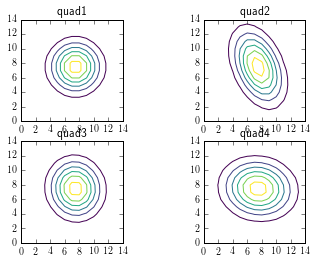

In [40]:
for i in range(4):
    shape = shapes[i:i+1]
    plt.subplot(2, 2, i+1, aspect='equal')
    stamp = models.Gaussian2D(x_mean=fitshape[0]/2., y_mean=fitshape[1]/2., 
                              x_stddev=shape['sgx'], y_stddev=shape['sgy'], theta=shape['theta'])
    plt.contour(stamp(x, y), cmap='viridis')
    plt.title('quad{}'.format(i+1))
    
    #plt.grid()

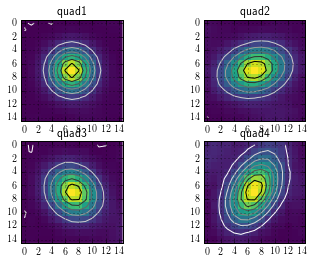

In [41]:
for i in range(4):
    plt.subplot(2, 2, i+1, aspect='equal')
    plt.imshow(star_staq[i], cmap='viridis', interpolation='none')
    plt.contour(star_staq[i], cmap='gray_r')
    plt.grid()
    plt.title('quad{}'.format(i+1))

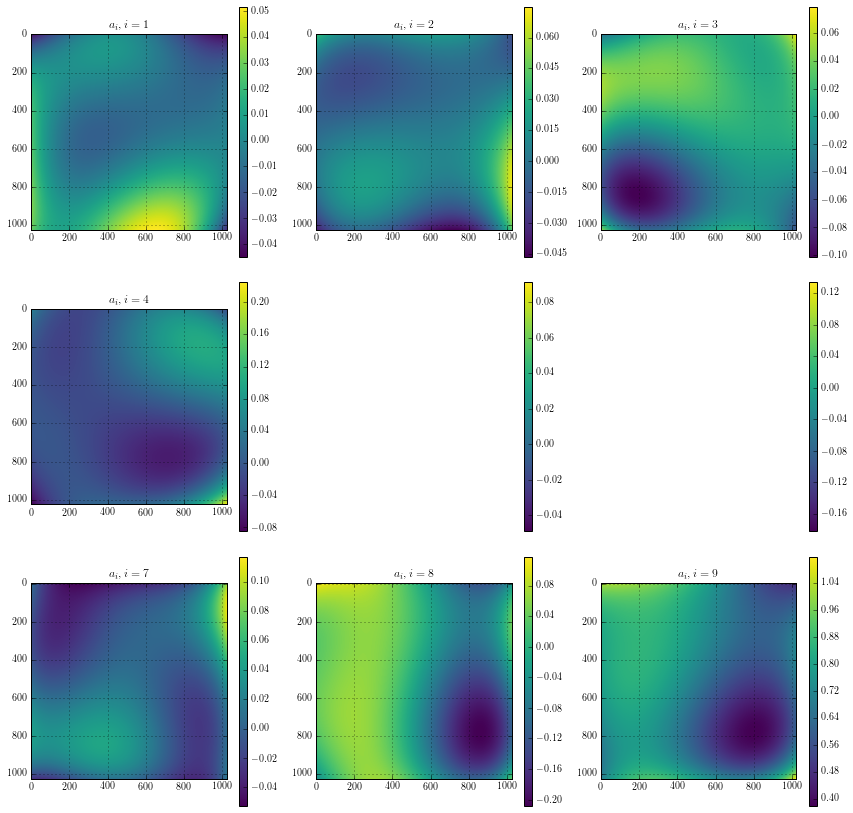

In [42]:
size = 4
a_fields = np.copy(afields)
imshape = im.bkg_sub_img.shape
N = len(a_fields)
p = utils.primes(N)
if N == 2:
    subplots = (2, 1)
elif p == N:
    subplots = (np.rint(np.sqrt(N)),  np.rint(np.sqrt(N)))
else:
    subplots = (N/float(p), p)

plt.figure(figsize=(size*subplots[0], size*subplots[1]))
x, y = np.mgrid[:imshape[0], :imshape[1]]
for i in range(len(a_fields)):
    plt.subplot(subplots[1], subplots[0], i+1)
    field = a_fields[i](x, y)
    plt.imshow(field, cmap='viridis')
    plt.title(r'$a_i, i = {}$'.format(i+1))
    plt.tight_layout()
    plt.colorbar(shrink=0.85, aspect=30)
    plt.grid()
plt.savefig('afields_no_seaborn.pdf', dpi=400)

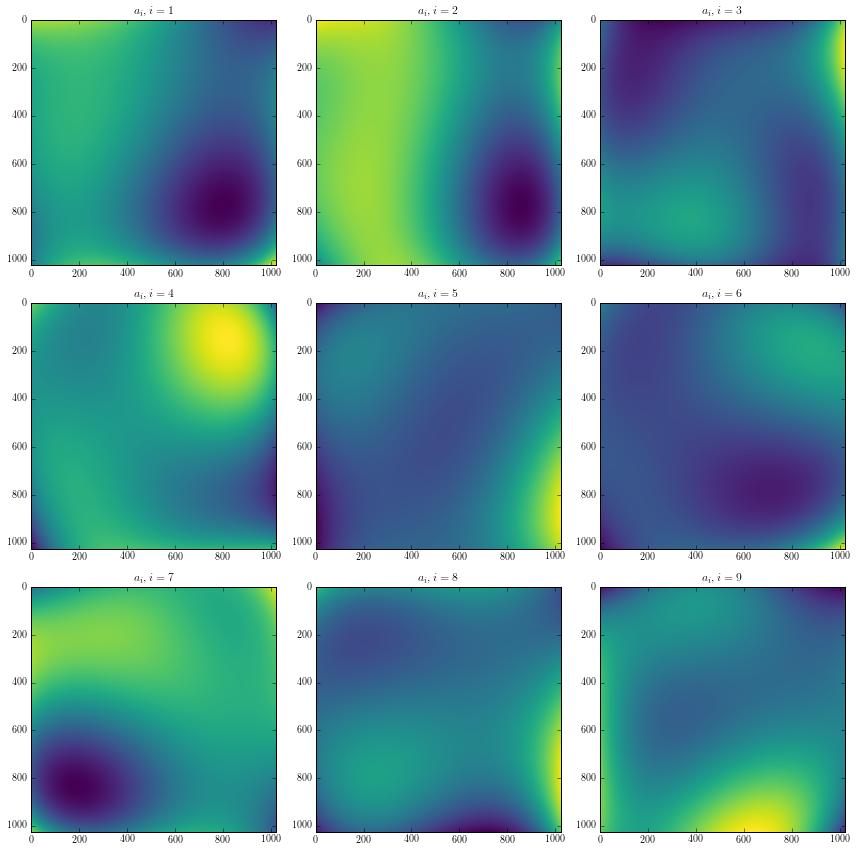

In [43]:
utils.plot_afields(afields, imshape, nbook=True)

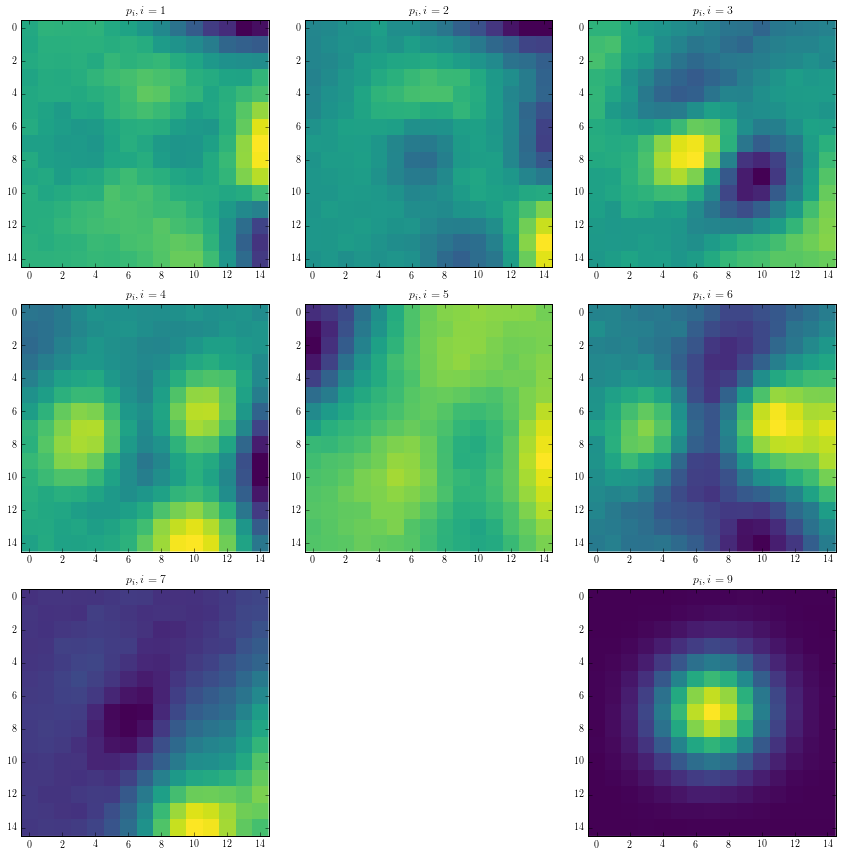

In [44]:
utils.plot_psfbasis(psf, nbook=True, path='psf_basis_2.pdf', interpolation='none', grid=False)

Now we get the reconstruction using the deltas.

In [45]:
reload(pc)
im = pc.SingleImage(imgfile, pow_th=0.001)

In [46]:
afield, psf = im.get_variable_psf()

background subtracted image obtained
background subtracted image obtained
raw sources = 350
Sources good to calculate = 180
returning best sources

Fitshape = (15, 15)
obtainig KL basis, using k = 9
returning variable psf


In [47]:
img = fits.open(imgfile)
dat = img[0].data.byteswap().newbyteorder()
bkg = sep.Background(dat)
src = sep.extract(dat - bkg, thresh=5.*bkg.globalrms)

In [48]:
weights = 100000. * src['flux']/max(src['flux'])

In [49]:
xy = [(int(row['y']), int(row['x'])) for row in src]

In [50]:
from properimage import simtools
m = simtools.delta_point(1024, center=False, xy=xy, weights=weights)
x, y = np.mgrid[:imshape[0], :imshape[1]]

rebuild = np.zeros(imshape)
for i in range(len(psf)):
    psf_i = psf[i]
    # psf_i = psf_i/np.sqrt(np.sum(psf_i**2.))
    a = a_fields[i]
    rebuild += a(x, y) * simtools.convol_gal_psf_fft(m, psf_i)


In [51]:
r = fits.PrimaryHDU(rebuild)
r.writeto('./frame_rebuild2.fits', clobber=True)

In [52]:
rebuildfile = './frame_rebuild2.fits'

In [53]:
rebuild_im = pc.SingleImage(rebuildfile)

rebuild_star_staq = [np.zeros(fitshape) for i in range(4)]
cum = [0, 0, 0, 0]
y, x = np.mgrid[:fitshape[1], :fitshape[0]]
for pos in rebuild_im._best_srcs['positions']:
    if pos[1]<512 and pos[0]<=512:
        i_quad = 0
    elif pos[1]>=512 and pos[0]<=512:
        i_quad = 1
    elif pos[1]<512 and pos[0]>512: 
        i_quad = 2
    elif pos[1]>=512 and pos[0]>512:  
        i_quad = 3
    
    rebuild_star_staq[i_quad] += pc.extract_array(rebuild_im.bkg_sub_img, fitshape, 
                                                  pos, fill_value=rebuild_im.bkg.globalrms)
    cum[i_quad] += 1

for i_quad in range(4):
    rebuild_star_staq[i_quad] = rebuild_star_staq[i_quad]/cum[i_quad]
    rebuild_star_staq[i_quad] = rebuild_star_staq[i_quad]/np.sum(rebuild_star_staq[i_quad])


background subtracted image obtained
background subtracted image obtained
raw sources = 363
Sources good to calculate = 182
returning best sources



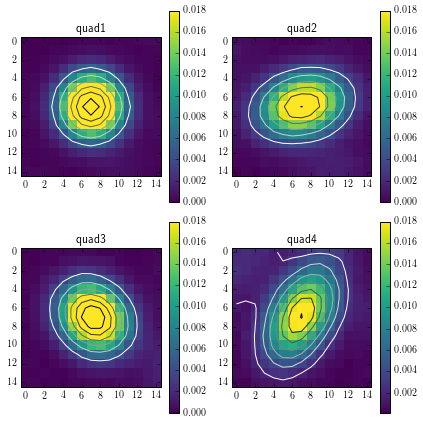

In [117]:
plt.figure(figsize=(6, 6))
for i in range(4):
    plt.subplot(2, 2, i+1, aspect='equal')
    plt.imshow(star_staq[i], cmap='viridis', interpolation='nearest', vmax=0.018)
    plt.colorbar()
    plt.contour(rebuild_star_staq[i], cmap='gray_r', linewidth=0.01)
    #plt.grid()
    plt.title('quad{}'.format(i+1))

plt.tight_layout()
plt.savefig('contours_no_seaborn.svg', dpi=600)

In [55]:
for apsf in psf:
    print np.sum(apsf**2.)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [65]:
pix_q1 = dat[0:512, 0:512]
q1rms = sep.Background(np.ascontiguousarray(pix_q1)).globalrms
print  sep.Background(np.ascontiguousarray(pix_q1)).globalback

pix_q2 = dat[512:, 0:512]
q2rms = sep.Background(np.ascontiguousarray(pix_q2)).globalrms
print  sep.Background(np.ascontiguousarray(pix_q2)).globalback

pix_q3 = dat[0:512, 512:]
q3rms = sep.Background(np.ascontiguousarray(pix_q3)).globalrms
print  sep.Background(np.ascontiguousarray(pix_q3)).globalback

pix_q4 = dat[512:, 512:]
q4rms = sep.Background(np.ascontiguousarray(pix_q4)).globalrms
print  sep.Background(np.ascontiguousarray(pix_q4)).globalback

q_rms = [q1rms, q2rms, q3rms, q4rms]

894.538818359
787.085754395
789.801452637
808.334960938


In [62]:
print q1rms, q2rms, q3rms, q4rms

26.3938941956 24.2155132294 24.3735237122 24.8274612427


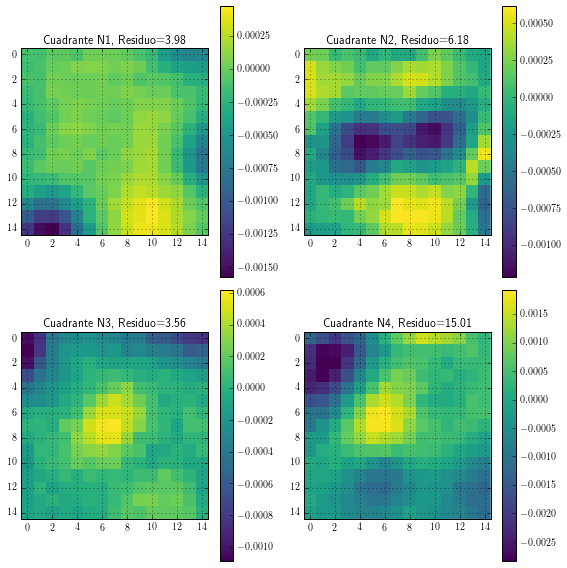

In [91]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2, 2, i+1, aspect='equal')
    factor = np.median(star_staq[i]/rebuild_star_staq[i])
    res=star_staq[i]-factor*rebuild_star_staq[i]
    plt.imshow(res, cmap='viridis', interpolation='none')
    plt.colorbar()
    #plt.contour(rebuild_star_staq[i], cmap='gray_r', linewidth=0.01)
    plt.grid()
    plt.title('Cuadrante N{}, Residuo={:.2%}'.format(i+1, np.sqrt(np.sum(res**2.)/np.sum(star_staq[i]**2.))))

plt.tight_layout()
#plt.savefig('residual.pdf', dpi=400) 

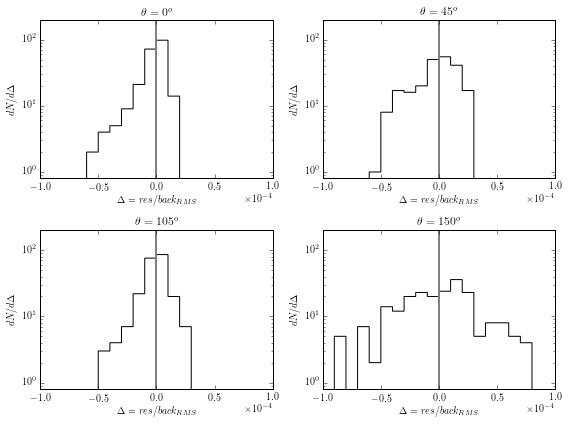

In [130]:
bins = np.arange(-9.e-5, 1.0e-4+1e-5, 1e-5)
plt.figure(figsize=(8, 6))
angles = [0, 45, 105, 150]
for i in range(4):
    plt.subplot(2, 2, i+1)#, aspect='equal')
    factor = np.median(star_staq[i]/rebuild_star_staq[i])
    res = (star_staq[i]-factor*rebuild_star_staq[i])/q_rms[i]
    plt.hist(res.flatten(), log=True, bins=bins, histtype='step', color='black')
    plt.axvline(np.median(star_staq[i]-factor*rebuild_star_staq[i]), color='gray', lw=2.)

    plt.title(r'$\theta={}^o$'.format(angles[i]))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ylabel(r'$dN/d\Delta$')
    plt.ylim(0.8, 200)
    plt.xlabel(r'$\Delta = res/back_{RMS}$')
plt.tight_layout()
plt.savefig('residual_hist.pdf', dpi=400)

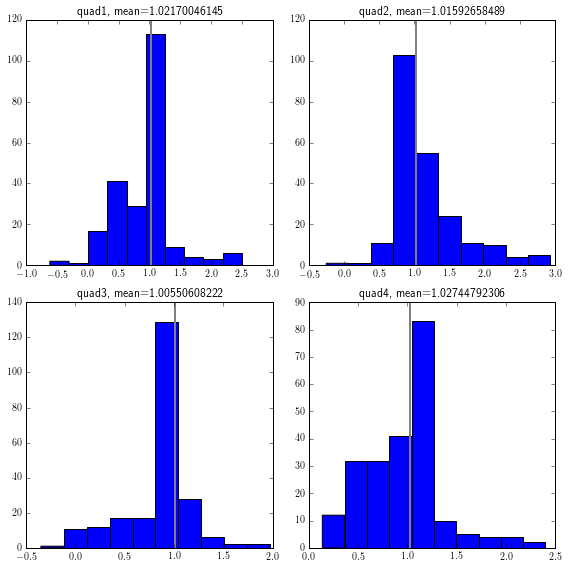

In [95]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2, 2, i+1)#, aspect='equal')
    plt.hist((star_staq[i]/rebuild_star_staq[i]).flatten())
    plt.axvline(np.median(star_staq[i]/rebuild_star_staq[i]), color='gray', lw=2.)
    plt.title('quad{}, mean={}'.format(i+1, np.median(star_staq[i]/rebuild_star_staq[i])))

plt.tight_layout()
